In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [6]:
# Loading the Dataset
df = pd.read_csv('/content/reviews.csv')  # Upload and use your dataset here
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
# Label Encoding (Converting 'sentiment' column into binary format: Positive → 1, Negative → 0)
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x.lower() == 'positive' else 0)

In [12]:
# Defining a text Preprocessing function
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()  # lowercasing
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation
    tokens = word_tokenize(text)  # tokenize the text
    filtered = [w for w in tokens if w not in stop_words]  # stop words removal
    return filtered

# Apply preprocessing to each text entry
df['tokens'] = df['review'].apply(preprocess)

In [13]:
# Building Vocabulary from all words in the dataset
all_words = [word for tokens in df['tokens'] for word in tokens]
vocab = sorted(set(all_words))

# Mapping each word to a unique index (start from 1; 0 will be reserved for padding)
word2idx = {w: i+1 for i, w in enumerate(vocab)}  # index starts from 1
vocab_size = len(word2idx) + 1  # +1 for padding (0)

# Encode tokens using the vocabulary index
def encode(tokens):
    return [word2idx[word] for word in tokens if word in word2idx]

df['encoded'] = df['tokens'].apply(encode)

In [14]:
# Padding or truncate sequences to a fixed length (max_len)
max_len = 100

def pad_seq(seq):
    if len(seq) > max_len:
        return seq[:max_len]  # Truncate longer sequences
    else:
        return [0]*(max_len - len(seq)) + seq  # left-padding shorter ones with 0

df['padded'] = df['encoded'].apply(pad_seq)


In [16]:
# Train-Test Split

# Preparing features and labels
X = np.array(df['padded'].tolist())
y = df['sentiment'].values

# Splitting into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Define a PyTorch Dataset class to load data
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [18]:
# Defining the LSTM-based Sentiment Analysis Model
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # Word embedding layer
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)  # LSTM Layer
        self.fc = nn.Linear(hidden_dim, 1)  # Output layer (binary)
        self.sigmoid = nn.Sigmoid() # Activation for binary classification

    def forward(self, x):
        x = self.embedding(x) # Convert indices to embeddings
        _, (h_n, _) = self.lstm(x) # Get final hidden state
        out = self.fc(h_n[-1])  # Pass through fully connected layer
        return self.sigmoid(out).squeeze()  # Apply sigmoid to get probability

In [19]:
# Initializing the Model, loss function, and optimizer
embed_dim = 64
hidden_dim = 128

model = SentimentLSTM(vocab_size, embed_dim, hidden_dim)
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Training Loop for the model
num_epochs = 5
train_loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()   # Clear gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward() # Backpropagation
        optimizer.step()  # Update weights
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/5, Loss: 0.6349
Epoch 2/5, Loss: 0.3892
Epoch 3/5, Loss: 0.2626
Epoch 4/5, Loss: 0.1978
Epoch 5/5, Loss: 0.1241


In [21]:
# Evaluating the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = (outputs > 0.5).float()  # Convert probabilities to 0 or 1
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [22]:
# Computing accuracy, precision, and recall
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)

print(f"\nAccuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")


Accuracy: 0.8580, Precision: 0.8445, Recall: 0.8803


In [23]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[4144  817]
 [ 603 4436]]


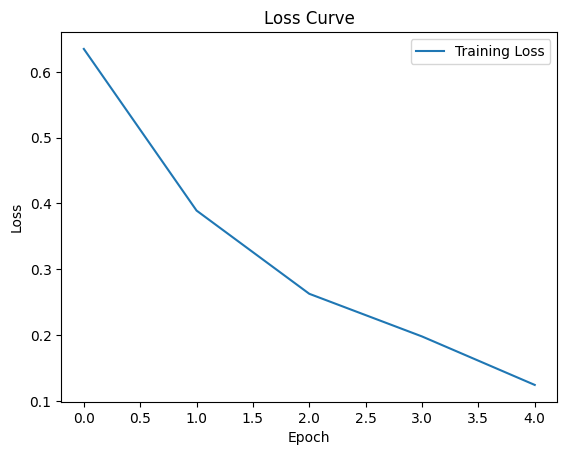

In [24]:
# Plot of Training Loss
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# **Summary: Preprocessing & Model Rationale**

**Training Results:**

Epoch 1/5, Loss: 0.6349

Epoch 2/5, Loss: 0.3892

Epoch 3/5, Loss: 0.2626

Epoch 4/5, Loss: 0.1978

Epoch 5/5, Loss: 0.1241

---


**Final Metrics**
Accuracy: **0.8580**, Precision: **0.8445**, Recall: **0.8803**
 
 ---

***The model performed well, identifying sentiment with reasonably high precision and recall.***

**Confusion Matrix:**

[[4144  817]

 [ 603 4436]]

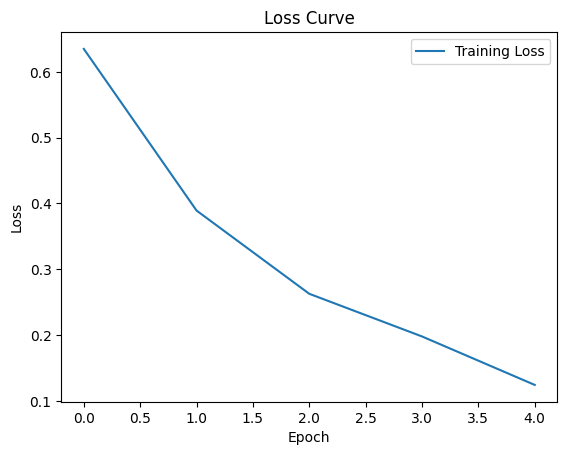

**1.   Data Preprocessing**



* Lowercasing: Reduces vocabulary size and treats words like Good and good equally.



*   Punctuation Removal & Tokenization: Cleans and splits text into words for model input.


*   Stopword Removal: Removes common words (like “the”, “is”) that don’t affect sentiment.



*   Encoding & Padding: Converts words to indices and pads/truncates all sequences to length 100 for LSTM compatibility.



**2.  Model Architecture**

* Embedding Layer: Converts word indices into dense vectors that capture meaning.

* LSTM Layer: Processes sequences and captures context and sentiment dependencies.

* Fully Connected + Sigmoid: Outputs a probability for binary classification (positive/negative).


**3. Design Choices**

* Loss Function: Binary Cross-Entropy (BCELoss) — standard for binary tasks.

* Optimizer: Adam — fast and adaptive for NLP.

* Metrics: Accuracy, Precision, Recall to evaluate both correctness and relevance.

**Final Thoughts:**

A simple LSTM model with clean preprocessing gives strong baseline performance. The setup is easy to extend with dropout, more layers, or pretrained embeddings like GloVe for better results.